# HQNSL for 1-qubit operations
This notebook is a test of the HQNSL scheme for the simplest parametrization of a quantum circuit: a collection of `depth` sets of `L` 1-qubit rotations given by `L x 2` parameters per set. We will learn in 2 bases and examine the effectiveness of the algorithm.

In [1]:
from __helpers import qubit_expansion, prepare_basis, rand_basis
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL, Em_MMD, MMD
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi
from qiskit.quantum_info import Statevector
%matplotlib inline

## Construction of the State

In [15]:
"""
The below flags control all the main parts of a run. The only things you
would need to change besides these is the optimization parameters, like which
algorithm to use, learning rate, maximum iterations, etc.

When using KL, set `OPS = None`. When using Em_MMD, set `ops = s` 
where `s` is the desired MMD parameter.
"""
CIRCUIT_DEPTH = 0 # Depth of the parameterized quantum circuit
STATE_TYPE = 'XY'
NUM_QUBITS = 4
NUM_BASES = 2
USE_REGULARIZER = False
LOSS_METRIC = KL
ESTIMATE = False
SAMPLE = False
NOISE_SCALE = 5
OPS = None # MMD sigma parameter

## Which loss to use?
KL seems great.

MMD loss doesn't work. It won't converge in time, and it produces things that are far from symmetries.

Running on the CPU
Ground state norm: 1.0


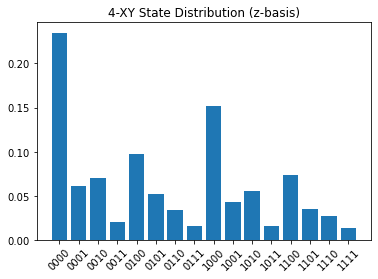

In [16]:
"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'mGHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from mGHZ_generator import mGHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = mGHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.xticks(rotation=45)
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## HQN Training
We will construct the bases we want as a list of `L x 3` rotation-parameter matrices, then pass them into the hybrid quantum net and run the optimization algorithm. 

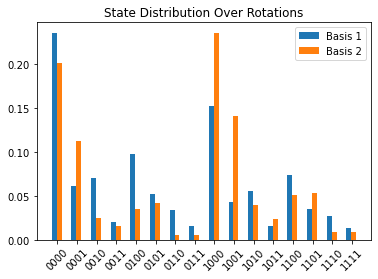

In [23]:
# Preparation of two bases
bases = prepare_basis(state.num_qubits, num=NUM_BASES, init=0)
num_bases = len(bases)

# Visualize the distribution of the bases
fig, ax = plt.subplots()
for i, basis in enumerate(bases):
    dist_i = BasisTransformer([state], basis).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.04*state.num_qubits, dist_i, width=0.25)
    bar.set_label(f"Basis {i+1}")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.xticks(rotation=45)
plt.title("State Distribution Over Rotations")
plt.show()

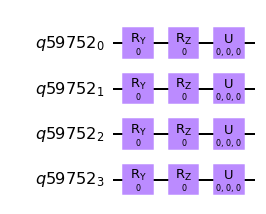

In [24]:
# Start up the HQN
disp = False # Display convergence messages from optimizer

hqn = HQNet(state, bases, eta=1e-2, maxiter=1E4, disp=disp,
            mode='Nelder-Mead', depth=CIRCUIT_DEPTH, 
            estimate=ESTIMATE, s_eps=NOISE_SCALE, 
            metric_func=LOSS_METRIC, ops=OPS, sample=SAMPLE, 
            regularize=USE_REGULARIZER)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [25]:
# Optimize a few times.
NRUN = 5
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim))
avg = 0
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss, regularizer_loss = hqn.find_potential_symmetry(print_log=True)
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
print(f"\nAverage loss: {avg}")

# ? | Ooen question: `regularizer_loss` gives a list (one element per basis) of losses over time
# ? | that the regularizer CNets report during their batch training. These can be plotted
# ? | to see how well the regularizer is learning. In particular, if the paths start out in
# ? | totally different parts of the manifold, does the regularizer learn it well? If so, we 
# ? | are in trouble. We want the CNets to intentionally overfit, so it extrapolates relatively
# ? | poorly.

Optimized to loss metric = 0.006637256592512131
Queried loss func 1918 times
Optimized to loss metric = 0.005458399653434753
Queried loss func 2060 times
Optimized to loss metric = 0.003531862050294876
Queried loss func 2148 times
Optimized to loss metric = 0.006055853329598904
Queried loss func 2180 times
Optimized to loss metric = 0.003531862050294876
Queried loss func 1801 times

Average loss: 0.005043046735227107


### LD-GHZ Scalability
At least for a small number of qubits, the query complexity seems to scale linearly or sublinearly with the circuit depth.

* Nelder-Mead query complexity appears to scale exponentially with number of qubits.
* NFT scales a bit better, but is not accurate either.
* 3 qubits, `depth = k`, `2500 * k` queries. 
* 4 qubits, `depth = 3`, 16000 queries. Doesn't seem to depend on depth.
* 5 qubits, `depth = 2`, 15000 queries.
* 6 qubits, `depth = 2`, 13000 queries.
* 7 qubits, `depth = 2`, 26000-45000 queries.

There is evidently a sharp query complexity increase at 7 qubits. What is happening?
The number of parameters is `L x D x 2`. The adaptive Nelder-Mead algorithm apparently adaps well up to 30 
parameters or so, then takes much longer to search. Nonteheless, accuracy was not compromised, which is good news.

### LD-mGHZ Analysis
A "general" state like the mGHZ state probably doesn't have any nontrivial symmetries. This explains the high quantum loss validation. It is interesting to note, however, that the learning scheme finds what I like to call `k`-projective pseudosymmetries. Given a set of bases, there exists operators that are symmetries in those bases. Naively, we might imagine that we can use `k` to test for whether a symmetry is real: just keep increasing `k` until the learner breaks down. But there is a much more efficient way---look at the QCV error. If that is high, we immediately know that the learning scheme has only found a `k`-projective pseudosymmetry. If not, the symmetry is true. In general, **there is a tradeoff between confidence and accuracy**. If you want to be sure that the scheme finds symmetries, use 3 orthogonal bases. But the state cannot be poly-sparse in all of them, so this is exponentially hard. On the other hand, if you want to be efficient, find a poly-sparse basis and rotate locally around it. If the state really has symmetries, with high probability you will find it. If it doesn't, you will find `k`-projective pseudosymmetries, but you will be able to know this by the quantum cross validation.

Note that in general, computing the QCV loss is exponetially hard since the basis is random. However, this is not a huge issue, since we are not learning with it, but just checking once at the end. If we had to learn with it, i.e. do millions/billions of calculations with it, one for each iteration, then the scheme is infeasible. 

### Comparison of Optimizers in 3-GHZ
tl;dr Nelder-Mead and NFT works best

We define `LA = A | B` to be the average loss `A` over `B` runs, throwing out extreme outliers. Times given are per run. The below results are for the 3-qubit GHZ state.

#### Local optimizers
1. Vanilla gradient descent is extremely slow (`~3 min`) and performs moderately poorly (`LA = 0.021 | 100`)
2. Adam is super fast (`<1 sec`) but performs very poorly (`LA = 3.77 | 1000`)
3. Nelder-Mead is very fast (`~5 sec`) and performs very well, needs `~1000` queries (`LA = 1e-14 | 100`).
4. Conjugate gradient is super fast (`<1 sec`) but performs very poorly (`LA = 3.171 | 1000`)
5. NFT is very fast (`~5 sec`) and performs well (`LA = 1e-5 | 100`).
6. SPSA is very slow (`~40 sec`) and performs reasonably well (`LA = 0.0036 | 100`)
7. TNC is extremely fast (`<<1 sec`) but performs very poorly (`LA = 3.62 | 1000`)
8. AQGD: I cannot get it to run. Seems like they are running some strange batch training which is not compatible
with my loss function `param_to_quantum_loss`. Too bad.

#### Global optimizers
1. TODO


## Quantum Training Validation
The quantum loss function is a sum over the classical loss metric projected into each basis, so let's first make sure that
the loss is uniformly and sufficiently small in each of the bases we used in the search.

In [26]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape(param_shape)}\n")
    for basis_here in bases:
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tKL value for training basis {basis_here[0]} is: {loss_metric}")
        
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=LOSS_METRIC, say_hi=False, ops=OPS).evaluate_true_metric(sym)
        print(f"\tPresent loss metric for training basis {basis_here[0]} is: {loss_metric}")

Analysing proposed symmetry 1:
tensor([[[ 2.1180,  2.8929,  5.9748]],

        [[-0.0128,  0.3768,  3.0870]],

        [[ 3.7687,  3.2845,  4.5165]],

        [[ 2.7873,  2.9626,  1.6330]]])

	KL value for training basis tensor([0., 0., 0.]) is: 0.004059374937883113
	Present loss metric for training basis tensor([0., 0., 0.]) is: 0.004059374937883113
	KL value for training basis tensor([0.3142, 0.0000, 0.0000]) is: 0.0025778818509111824
	Present loss metric for training basis tensor([0.3142, 0.0000, 0.0000]) is: 0.0025778818509111824


Analysing proposed symmetry 2:
tensor([[[ 6.2829e+00,  6.1953e+00,  1.5856e-01]],

        [[ 4.1997e+00,  3.5140e+00,  2.2225e+00]],

        [[-7.4749e-04,  6.2154e+00,  2.3869e+00]],

        [[ 6.2785e+00, -8.2375e-01,  4.4443e+00]]])

	KL value for training basis tensor([0., 0., 0.]) is: 0.003211095710189895
	Present loss metric for training basis tensor([0., 0., 0.]) is: 0.003211095710189895
	KL value for training basis tensor([0.3142, 0.0000, 0.00

## Quantum Loss Cross-Validation
We chose a small number of bases to run the quantum loss scheme over. But are those bases enough? 
If the proposed symmetries are truly symmetries, then they will be a symmetry in every basis. We shall test
these proposed symmetries by choosing some random bases, applying the quantum circuit, and examining the loss metric there.

If the loss metric is high there, then we did not use enough bases in the quantum loss function.

Note that this has more general implications, as the number of bases necessary to achieve a good quantum loss function
informs the amount of information necessary to construct a reasonable tomography of the state.

In [27]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape(param_shape)}\n")
    for _ in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tKL value for random basis {basis_here[0]} is: {loss_metric}")
        
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=LOSS_METRIC, say_hi=False, ops=OPS).evaluate_true_metric(sym)
        print(f"\tPresent loss metric for random basis {basis_here[0]} is: {loss_metric}")
    print('\n')

Analysing proposed symmetry 1:
tensor([[[ 2.1180,  2.8929,  5.9748]],

        [[-0.0128,  0.3768,  3.0870]],

        [[ 3.7687,  3.2845,  4.5165]],

        [[ 2.7873,  2.9626,  1.6330]]])

	KL value for random basis tensor([2.4917, 0.0572, 1.9235]) is: 0.15372658762830121
	Present loss metric for random basis tensor([2.4917, 0.0572, 1.9235]) is: 0.15372658762830121
	KL value for random basis tensor([5.3437, 4.2679, 1.0887]) is: 0.2821663576811758
	Present loss metric for random basis tensor([5.3437, 4.2679, 1.0887]) is: 0.2821663576811758
	KL value for random basis tensor([4.7700, 4.7752, 0.1802]) is: 0.10295199227827118
	Present loss metric for random basis tensor([4.7700, 4.7752, 0.1802]) is: 0.10295199227827118




Analysing proposed symmetry 2:
tensor([[[ 6.2829e+00,  6.1953e+00,  1.5856e-01]],

        [[ 4.1997e+00,  3.5140e+00,  2.2225e+00]],

        [[-7.4749e-04,  6.2154e+00,  2.3869e+00]],

        [[ 6.2785e+00, -8.2375e-01,  4.4443e+00]]])

	KL value for random basis te